In [1]:
__version__ = '20180806'

# Imports and setup
We import all modules required for this notebook.

In [2]:
# std. lib
import sys
sys.path.append('../../../hypercat/hypercat/')

# 3rd party
import pylab as plt

# hypercat
import hypercat
import plotting
import bigfileops as bfo
import ioops

In [46]:
###----------------HDF file dir-------------------###
hdffile = '/Volumes/Kohei_HDD_201803/hypercat/hypercat_20180417.hdf5'
#hdffile = '/home/robert/data/hypercat/hypercat_20180417.hdf5'

# Map the image hypercube in memory
The simplest way to access the image data in the hypercube is via the 'ontheflymode':

In [47]:
imgcube = hypercat.ModelCube(hdffile, hypercube='imgdata', subcube_selection='minimal')

Opening HDF5 file: /Volumes/Kohei_HDD_201803/hypercat/hypercat_20180417.hdf5 
Loading sampling parameters.
Closing HDF5 file.
Loading  hypercube 'imgdata' [shape: (5,10,16,12,5,7,19,121,241)] to RAM (693.51 GB required) ...
Inspect the loaded hypercube with .print_sampling()

-------------------------------------------------------
Parameter  Range                Nvalues  Sampled values
-------------------------------------------------------
 sig*    [ 15.000 -  75.000]  (  5)    15.000, 30.000, 45.000, 60.000, 75.000
   i*    [  0.000 -  90.000]  ( 10)     0.000, 10.000, 20.000, 30.000, 40.000, 50.000, 60.000, 70.000, 80.000, 90.000
   Y*    [  5.000 -  20.000]  ( 16)     5.000,  6.000,  7.000,  8.000,  9.000, 10.000, 11.000, 12.000, 13.000, 14.000, 15.000, ...
   N*    [  1.000 -  12.000]  ( 12)     1.000,  2.000,  3.000,  4.000,  5.000,  6.000,  7.000,  8.000,  9.000, 10.000, 11.000, ...
   q*    [  0.000 -   2.000]  (  5)     0.000,  0.500,  1.000,  1.500,  2.000
  tv*    [ 10.000 -

the option `hypercube='imgdata'` is selected for obtaining the image (intensity) map. You can also choose `hypercube='clddata'` for the cloud map and will describe it later.
This method does not load any data into memory yet, i.e. it is very convenient to inspect the content of the cube.
All parameter names printed in bold (or marked with an asterisk) can be continuously interpolated with the cube's envelope.

## Get images via low-level functions
For obtaining the images, the set of clumpy torus parameters as well as the target wavelength(s) should be specified. 
The CLUMPY parameters are $\sigma, i, Y, N_0, q, \tau_{\rm V}$ (please check [official clumpy website for more details](https://www.clumpy.org/pages/model-description.html)).

There is one rule for making a vector of model parameter values for which we would like to see the image. Specify only the interpolatable model parameters printed in **bold** and/or masked with an asterisk (*), in the order printed in the table above (and including the wavelength in microns). This can be done like this:

In [71]:
sig, i, Y, N, q, tv, wave = 43, 75, 18, 4, 0.08, 70, 12.0  # example parameters, here e.g. for NGC1068 from Lopez-Rodriguez+2018
vec = (sig, i, Y, N, q, tv, wave) #The order of the parameter set is also important...

Making the model image is very simple by using `imgcube`

In [81]:
img = imgcube(vec)

Squeezing all dim-1 axes...
Instantiating n-dim interpolation object ...
Done.


Then let's plot. #WE NEED TO EXPLAIN HERE WHY THE IMAGE IS STORED IN THE HORIZONTAL DIRECTION.

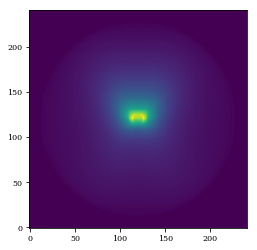

In [50]:
plt.imshow(img.T, origin='lower')

You can also use Hypercat's convenient function `plotting`: (HERE, why do we need ;?)

Plotting panel (0,0)


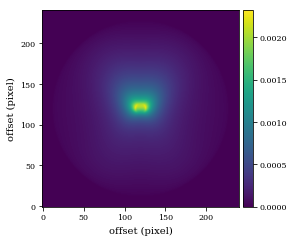

In [51]:
plotting.multiplot(img);

# Store the subcube information into `.json` file (**you can skip this tep**)
The interactive selection of per-axis indices can be stored for future use in a json file, an open-standard and human-readable file format.  Simply provide a file name as argument `subcube_selection_save`. **This will start a small program in the terminal window to help you select the interesting parameter values, one axis at a time. In your terminal window (not in the jupyter notebook)**, run the python command below:

``` python
foo/>cube = hypercat.ModelCube(hdffile, hypercube='imgdata', subcube_selection='interactive', subcube_selection_save='hypercatbasics.json')
```

Simply follow the instructions to select those parameter values you wish to retain in your sub-cube. The program will always update the displayed size of the currently selected sub-cube; this amount of data will be loaded into RAM, i.e. you must make sure not to exceed the available memory. After the final axis selection, the sub-cube is loaded into RAM, while some status messages are printed. A ta- ble of all model parameters in the hypercube with their avail- able sampling is also printed. 

# Load subcube from `.json` file
A subcube selection which was previously saved to a `.json` file (we provide one here) can be repeated non-interactively by loading from that file:

In [52]:
imgcube = hypercat.ModelCube(hdffile, hypercube='imgdata', subcube_selection='hypercatbasics.json')

Opening HDF5 file: /Volumes/Kohei_HDD_201803/hypercat/hypercat_20180417.hdf5 
Loading sampling parameters.
Closing HDF5 file.
Loading objects from file hypercatbasics.json.
Loading hyperslab [shape: (2,10,1,4,1,1,7,121,241)] from hypercube 'imgdata' [shape: (5,10,16,12,5,7,19,121,241)] to RAM (62.29 MB required) ...
Done.
Squeezing all dim-1 axes...
Instantiating n-dim interpolation object ...
Done.
Inspect the loaded hypercube with .print_sampling()

-------------------------------------------------------
Parameter  Range                Nvalues  Sampled values
-------------------------------------------------------
 sig*    [ 15.000 -  30.000]  (  2)    15.000, 30.000
   i*    [  0.000 -  90.000]  ( 10)     0.000, 10.000, 20.000, 30.000, 40.000, 50.000, 60.000, 70.000, 80.000, 90.000
   Y     [ 20.000 -  20.000]  (  1)    20.000
   N*    [  1.000 -   6.000]  (  4)     1.000,  4.000,  5.000,  6.000
   q     [  0.000 -   0.000]  (  1)     0.000
  tv     [ 40.000 -  40.000]  (  1)    40.

Note that this mode actually loads the subcube into memory immediately. Non-bold parameters are single-valued, and can thus not be interpolated. They are fixed. 

You can also interpolate images at multiple parameters vectors, e.g. multiple wavelengths:

In [53]:
wave = (2.2, 3.5, 8, 10)  # 4 wavelengths
vec = (30, 75, 5, wave) # sig, i, N, wave (only the bold-printed parameters)
img = imgcube(vec)
img.shape # note the shape of this "image": it has 4 slices in this case

(4, 241, 241)

You can extract the slices easily:

In [54]:
images = [img[j,...] for j in range(4)]

Plotting panel (0,0)
Plotting panel (0,1)
Plotting panel (0,2)
Plotting panel (0,3)


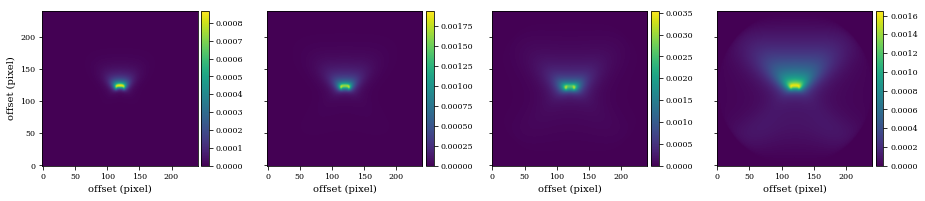

In [55]:
plotting.multiplot(images);

# Save a subcube to its own `.hdf5` file
A subcube selected in any fashion shown above and loaded into memory can be saved to a new hdf5 file using `bfo` (stands for **b**ig **f**ile **o**peration):

In [58]:
bfo.storeCubeToHdf5(imgcube, 'hypercatbasics_subcube.hdf5')

This file can be treated in the same way as the original Hypercat hdf5 file. In particular, the hypercube that it contains can be loaded in any of the ways described above (e.g. full-cube loading, interac- tive sub-cube selection, etc.)

Assuming that a (sub-)cube stored in a hdf5 file fits into the available memory, it can be loaded in its entirety like this:

In [61]:
imgcube = hypercat.ModelCube('hypercatbasics_subcube.hdf5', hypercube='imgdata', subcube_selection=None)

Opening HDF5 file: hypercatbasics_subcube.hdf5 
Loading sampling parameters.
Closing HDF5 file.
Loading  hypercube 'imgdata' [shape: (2,10,1,4,1,1,7,121,241)] to RAM (62.29 MB required) ...
Done.
Squeezing all dim-1 axes...
Instantiating n-dim interpolation object ...
Done.
Inspect the loaded hypercube with .print_sampling()

-------------------------------------------------------
Parameter  Range                Nvalues  Sampled values
-------------------------------------------------------
 sig*    [ 15.000 -  30.000]  (  2)    15.000, 30.000
   i*    [  0.000 -  90.000]  ( 10)     0.000, 10.000, 20.000, 30.000, 40.000, 50.000, 60.000, 70.000, 80.000, 90.000
   Y     [ 20.000 -  20.000]  (  1)    20.000
   N*    [  1.000 -   6.000]  (  4)     1.000,  4.000,  5.000,  6.000
   q     [  0.000 -   0.000]  (  1)     0.000
  tv     [ 40.000 -  40.000]  (  1)    40.000
wave*    [  2.200 -  10.000]  (  7)     2.200,  3.500,  4.800,  8.700,  9.300,  9.800, 10.000
   x     [  0.000 - 120.000]  

Once you save the `.hdf5` file, the loading time becomes considrably short.

# Hypercube of 2-d projected cloud maps

The hdf5 file comprises also a second cube, which contains the 2-d projected dust cloud maps, `clddata` instead of `imgdata`. Accessing it is analogous:

In [63]:
cldcube = hypercat.ModelCube(hdffile, hypercube='clddata', subcube_selection='hypercatbasics.json')

Opening HDF5 file: /Volumes/Kohei_HDD_201803/hypercat/hypercat_20180417.hdf5 
Loading sampling parameters.
Closing HDF5 file.
Loading objects from file hypercatbasics.json.
Loading hyperslab [shape: (2,10,1,1,121,241)] from hypercube 'clddata' [shape: (5,10,16,5,121,241)] to RAM (2.22 MB required) ...
Done.
Squeezing all dim-1 axes...
Instantiating n-dim interpolation object ...
Done.
Inspect the loaded hypercube with .print_sampling()

-------------------------------------------------------
Parameter  Range                Nvalues  Sampled values
-------------------------------------------------------
sig*    [ 15.000 -  30.000]  (  2)    15.000, 30.000
  i*    [  0.000 -  90.000]  ( 10)     0.000, 10.000, 20.000, 30.000, 40.000, 50.000, 60.000, 70.000, 80.000, 90.000
  Y     [ 20.000 -  20.000]  (  1)    20.000
  q     [  0.000 -   0.000]  (  1)     0.000
  x     [  0.000 - 120.000]  (121)     0.000,  1.000,  2.000,  3.000,  4.000,  5.000,  6.000,  7.000,  8.000,  9.000, 10.000, ...
 

We are only storing the maps for N0=1, since for higher N0 values, the maps are just to be multiplied by N0; their structure is otherwise identical. Let's check this by looking at the cloud map.

Plotting panel (0,0)


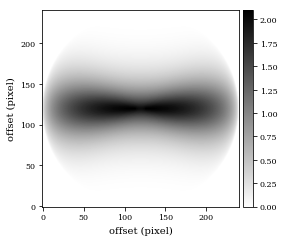

In [65]:
#imput of the cloud map
cldmap = cldcube((25,90)) # sig = 25 deg, i = 90 deg (= edge-on view)
#plot
plotting.multiplot(cldmap,cmap='gray_r');

In this edge-on view, the line of sight number of clouds along the central radial ray should be 2*N0 (front and back side of the cloud distribution). Since N0=1, we expect this to be =2. Let's check this by picking up the value of N0 at the center.

In [67]:
#pick up the central  pixel index
cpix = cldmap.shape[0]//2
print("Central pixel index: ", cpix)
print("Value at (cpix,cpix): %.1f (clouds along LOS)" % cldmap[cpix,cpix])

Central pixel index:  120
Value at (cpix,cpix): 2.0 (clouds along LOS)


# Create an AGN source (high-level API)

The above image does not contain any AGN source information. Hypercat includes a very useful abstraction of an AGN source.takes as input the hypercube of models and a number of other arguments. 
As we did, let's make imgcube first:

In [73]:
imgcube = hypercat.ModelCube(hdffile, hypercube='imgdata', subcube_selection='minimal')

Opening HDF5 file: /Volumes/Kohei_HDD_201803/hypercat/hypercat_20180417.hdf5 
Loading sampling parameters.
Closing HDF5 file.
Loading  hypercube 'imgdata' [shape: (5,10,16,12,5,7,19,121,241)] to RAM (693.51 GB required) ...
Inspect the loaded hypercube with .print_sampling()

-------------------------------------------------------
Parameter  Range                Nvalues  Sampled values
-------------------------------------------------------
 sig*    [ 15.000 -  75.000]  (  5)    15.000, 30.000, 45.000, 60.000, 75.000
   i*    [  0.000 -  90.000]  ( 10)     0.000, 10.000, 20.000, 30.000, 40.000, 50.000, 60.000, 70.000, 80.000, 90.000
   Y*    [  5.000 -  20.000]  ( 16)     5.000,  6.000,  7.000,  8.000,  9.000, 10.000, 11.000, 12.000, 13.000, 14.000, 15.000, ...
   N*    [  1.000 -  12.000]  ( 12)     1.000,  2.000,  3.000,  4.000,  5.000,  6.000,  7.000,  8.000,  9.000, 10.000, 11.000, ...
   q*    [  0.000 -   2.000]  (  5)     0.000,  0.500,  1.000,  1.500,  2.000
  tv*    [ 10.000 -

The source needs some properties, such as AGN luminosity, distance, position angle, (and the dust sublimation temperature, whose default argument is `tsub='1500 K'`) and a name. The object name is optional, but very useful if provided since if the object name can be resolved by Vizier, a proper WCS will be constructed.

In [76]:
#list of the parameters
Lbol = '1.6e45 erg/s'
D = '14.4 Mpc'
PA = '42 deg'
objectname = 'ngc1068'

`hypercat.Source` computes the torus size in physical units, and with the distance to the source, the pixel scale.

In [82]:
ngc1068 = hypercat.Source(imgcube,luminosity=Lbol,distance=D,pa=PA,objectname=objectname)

Again, let's define suitable CLUMPY model parameters (as before):

In [84]:
vec = (43,75,18,4,0.08,70,10.) #sigma,i,Y,N,q,tv,wave

Generate an image of the sky, properly distance-scaled and flux-calibrated:

In [93]:
sky = ngc1068(vec,total_flux_density='6.193 Jy') # data from Alonso-Herrero+2011
#WHAT DOES THE TOTAL FLUX DENSITY MEANS? IS IT A TOTAL FLUX AT 10 um?

Squeezing all dim-1 axes...
Instantiating n-dim interpolation object ...
Done.
Rotated image (see self.data) by 42.0 deg in direction 'NE'.
Coordinates for source 'ngc1068' resolved. WCS created.


The sky object is an instance of the Image class and has several useful members. The image is found in sky.data.  
The sky can be easily plotted by using `plotting.plot_with_wcs`:

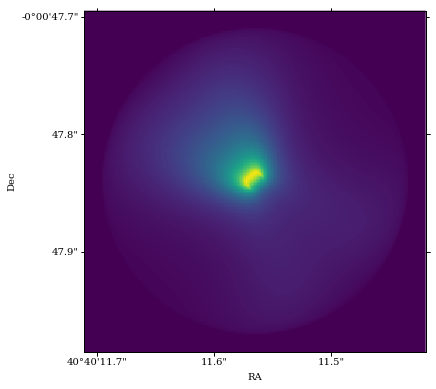

In [94]:
plotting.plot_with_wcs(sky)

The `plotting.mulplot` function also works if you are not interested in the actual coordinate.

Plotting panel (0,0)


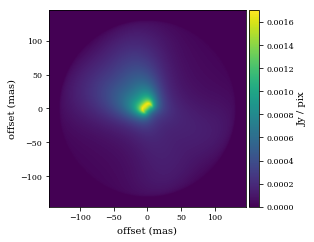

In [95]:
plotting.multiplot(sky);

Some of the properties of the sky image is stored in the instance of `sky`:

In [96]:
properties = ('objectname','pa','FOV','F','pixelscale','pixelarea')
for prop in properties:
    print("%12s: "%prop,getattr(sky,prop))

  objectname:  ngc1068
          pa:  42.0 deg
         FOV:  291.1041628123529 mas
           F:  6.192365904299143 Jy
  pixelscale:  1.2079010905076883 mas
   pixelarea:  1.4590250444496626 mas2


## Save image and metadata to FITS file (with header)
The sky image and its metadata can be saved to a FITS file using `ioops`:

In [98]:
ioops.save2fits(sky,'hypercatbasics_ngc1068.fits')

Existing FITS file 'hypercatbasics_ngc1068.fits' opened.
Data saved as new ImageHDU.
